# Station-keeping Sequence

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np

from ostk.core.filesystem import Directory

from ostk.mathematics.geometry.d3.objects import Cuboid
from ostk.mathematics.geometry.d3.objects import Composite
from ostk.mathematics.geometry.d3.objects import Point

from ostk.physics import Environment
from ostk.physics.coordinate import Frame
from ostk.physics.environment.atmospheric import Earth as EarthAtmosphericModel
from ostk.physics.environment.gravitational import Earth as EarthGravitationalModel
from ostk.physics.environment.magnetic import Earth as EarthMagneticModel
from ostk.physics.environment.objects.celestial_bodies import Earth
from ostk.physics.time import DateTime
from ostk.physics.time import Duration
from ostk.physics.time import Instant
from ostk.physics.time import Scale
from ostk.physics.time import Time
from ostk.physics.time import Interval
from ostk.physics.units import Length
from ostk.physics.units import Mass

from ostk.astrodynamics.trajectory.state import NumericalSolver
from ostk.astrodynamics.event_condition import RealCondition
from ostk.astrodynamics.trajectory.orbit.models.brouwerLyddaneMean import (
    BrouwerLyddaneMeanShort,
)
from ostk.astrodynamics.trajectory import StateBuilder
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory import Sequence
from ostk.astrodynamics.trajectory.state import CoordinatesSubset
from ostk.astrodynamics.trajectory.state.coordinates_subset import CartesianPosition
from ostk.astrodynamics.trajectory.state.coordinates_subset import CartesianVelocity
from ostk.astrodynamics import Dynamics
from ostk.astrodynamics.dynamics import Thruster
from ostk.astrodynamics.flight.system import SatelliteSystem
from ostk.astrodynamics.flight.system import PropulsionSystem
from ostk.astrodynamics.guidance_law import ConstantThrust
from ostk.astrodynamics.trajectory.orbit.models import Tabulated

## User inputs

Setup environment

In [2]:
earth = Earth.from_models(
    EarthGravitationalModel(
        EarthGravitationalModel.Type.EGM96, Directory.undefined(), 20, 20
    ),
    EarthMagneticModel(EarthMagneticModel.Type.Undefined),
    EarthAtmosphericModel(EarthAtmosphericModel.Type.Exponential),
)

environment = Environment(Instant.J2000(), [earth])

Initial state

In [3]:
instant = Instant.date_time(DateTime(2023, 1, 1), Scale.UTC)
initial_state = Orbit.sun_synchronous(
    instant, Length.kilometers(505.0), Time.midnight(), Earth.default()
).get_state_at(instant)

In [4]:
dry_mass = Mass.kilograms(100.0)
wet_mass = Mass.kilograms(110.0)

propulsion_system = PropulsionSystem(
    thrust_si_unit=1e-1, specific_impulse_si_unit=3000.0
)

## Setup Dynamics, initial state and Satellite System

In [5]:
satellite_geometry = Composite(
    Cuboid(Point(0.0, 0.0, 0.0), np.eye(3).tolist(), [1.0, 0.0, 0.0])
)

satellite_system = SatelliteSystem(
    dry_mass, satellite_geometry, np.eye(3), 500.0, 2.2, propulsion_system
)

In [6]:
state_builder = StateBuilder(
    frame=Frame.GCRF(),
    coordinates_subsets=[
        CartesianPosition.default(),
        CartesianVelocity.default(),
        CoordinatesSubset.mass(),
        CoordinatesSubset.surface_area(),
        CoordinatesSubset.drag_coefficient(),
    ],
)

coordinates = [
    *initial_state.get_coordinates().tolist(),
    wet_mass.in_kilograms(),
    satellite_system.get_cross_sectional_surface_area(),
    satellite_system.get_drag_coefficient(),
]

state = state_builder.build(initial_state.get_instant(), coordinates)

In [7]:
dynamics = Dynamics.from_environment(environment)
numerical_solver = NumericalSolver.default_conditional()

### Sequence

In [8]:
sequence = Sequence(
    numerical_solver=numerical_solver,
    dynamics=dynamics,
    maximum_propagation_duration=Duration.days(30.0),
    verbosity=5,
)

evaluator = (
    lambda state: BrouwerLyddaneMeanShort.cartesian(
        (state.get_position(), state.get_velocity()),
        EarthGravitationalModel.EGM2008.gravitational_parameter,
    )
    .get_semi_major_axis()
    .in_meters()
)

# coast till under 495.0
coast_condition = RealCondition(
    name="Mean SMA crossing - coast",
    criterion=RealCondition.Criterion.StrictlyNegative,
    evaluator=evaluator,
    target_value=EarthGravitationalModel.EGM2008.equatorial_radius.in_meters()
    + 495.0e3,
)
sequence.add_coast_segment(coast_condition)

# burn till at 500.0
thrust_condition = RealCondition(
    name="Mean SMA crossing - thrust",
    criterion=RealCondition.Criterion.StrictlyPositive,
    evaluator=evaluator,
    target_value=EarthGravitationalModel.EGM2008.equatorial_radius.in_meters()
    + 500.0e3,
)
sequence.add_maneuver_segment(
    event_condition=thrust_condition,
    thruster_dynamics=Thruster(satellite_system, ConstantThrust.intrack()),
)

In [9]:
sol = sequence.solve(state, 2)
states = sol.get_states()

[2024-02-06 22:10:06.807782] [0x00007f1f49c58280] [debug]   Solving Segment:
-- Segment -----------------------------------------------------------------------------------------
    Name:                                    Coast                                    
    Type:                                    Coast                                    
    Event Condition - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    Name:                                    Mean SMA crossing - coast                
    Target:                                  6.87314e+06                              
    Target Type:                             Absolute                                 
    Criterion:                               Strictly Negative                        
    
    Dynamics - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    Name:                                    Central Body Gravity [Earth]             
    Nam

[2024-02-06 22:10:07.443135] [0x00007f1f49c58280] [debug]   
-- Segment Solution --------------------------------------------------------------------------------
    Name:                                    Coast - Mean SMA crossing - coast - 0    
    Condition satisfied:                     True                                     
    Segment type:                            Coast                                    
    Start instant:                           2023-01-01 00:00:00 [UTC]                
    End instant:                             2023-01-01 00:33:37.352.961.924 [UTC]    
    Propagation duration:                    33:37.352.961.924                        
----------------------------------------------------------------------------------------------------


[2024-02-06 22:10:07.443278] [0x00007f1f49c58280] [debug]   Solving Segment:
-- Segment -----------------------------------------------------------------------------------------
    Name:                          

[2024-02-06 22:10:08.017896] [0x00007f1f49c58280] [debug]   
-- Segment Solution --------------------------------------------------------------------------------
    Name:                                    Maneuver - Mean SMA crossing - thrust - 0 
    Condition satisfied:                     True                                     
    Segment type:                            Maneuver                                 
    Start instant:                           2023-01-01 00:33:37.352.961.924 [UTC]    
    End instant:                             2023-01-01 01:36:45.422.767.359 [UTC]    
    Propagation duration:                    01:03:08.069.805.435                     
    Initial mass:                            110.0 [kg]                               
    Final mass:                              109.98712414601253 [kg]                  
    Total mass consumed:                     0.012875853987466712 [kg]                
------------------------------------------------------

[2024-02-06 22:10:10.127307] [0x00007f1f49c58280] [debug]   
-- Segment Solution --------------------------------------------------------------------------------
    Name:                                    Coast - Mean SMA crossing - coast - 1    
    Condition satisfied:                     True                                     
    Segment type:                            Coast                                    
    Start instant:                           2023-01-01 01:36:45.422.767.359 [UTC]    
    End instant:                             2023-01-01 06:06:57.499.126.416 [UTC]    
    Propagation duration:                    04:30:12.076.359.057                     
----------------------------------------------------------------------------------------------------


[2024-02-06 22:10:10.127580] [0x00007f1f49c58280] [debug]   Solving Segment:
-- Segment -----------------------------------------------------------------------------------------
    Name:                          

[2024-02-06 22:10:10.709267] [0x00007f1f49c58280] [debug]   
-- Segment Solution --------------------------------------------------------------------------------
    Name:                                    Maneuver - Mean SMA crossing - thrust - 1 
    Condition satisfied:                     True                                     
    Segment type:                            Maneuver                                 
    Start instant:                           2023-01-01 06:06:57.499.126.416 [UTC]    
    End instant:                             2023-01-01 07:09:30.418.381.867 [UTC]    
    Propagation duration:                    01:02:32.919.255.451                     
    Initial mass:                            109.98712414601253 [kg]                  
    Final mass:                              109.97436777064368 [kg]                  
    Total mass consumed:                     0.012756375368851991 [kg]                
------------------------------------------------------

----------------------------------------------




In [10]:
model = Tabulated(states, 0, Tabulated.InterpolationType.BarycentricRational)

In [11]:
orbit = Orbit(model, environment.access_celestial_object_with_name("Earth"))

In [12]:
interval = Interval.closed(states[0].get_instant(), states[-1].get_instant())
interpolated_states = orbit.get_states_at(
    interval.generate_grid(Duration.seconds(20.0))
)

In [13]:
data = []
for state in interpolated_states:
    blmshort = BrouwerLyddaneMeanShort.cartesian(
        (state.get_position(), state.get_velocity()),
        earth.get_gravitational_parameter(),
    )
    data.append(
        {
            "altitude": float(
                blmshort.get_semi_major_axis().in_kilometers()
                - earth.get_equatorial_radius().in_kilometers()
            ),
            "mass": float(state.get_coordinates()[6]),
            "time": state.get_instant().get_date_time(Scale.UTC),
        }
    )

In [14]:
df = pd.DataFrame(data)

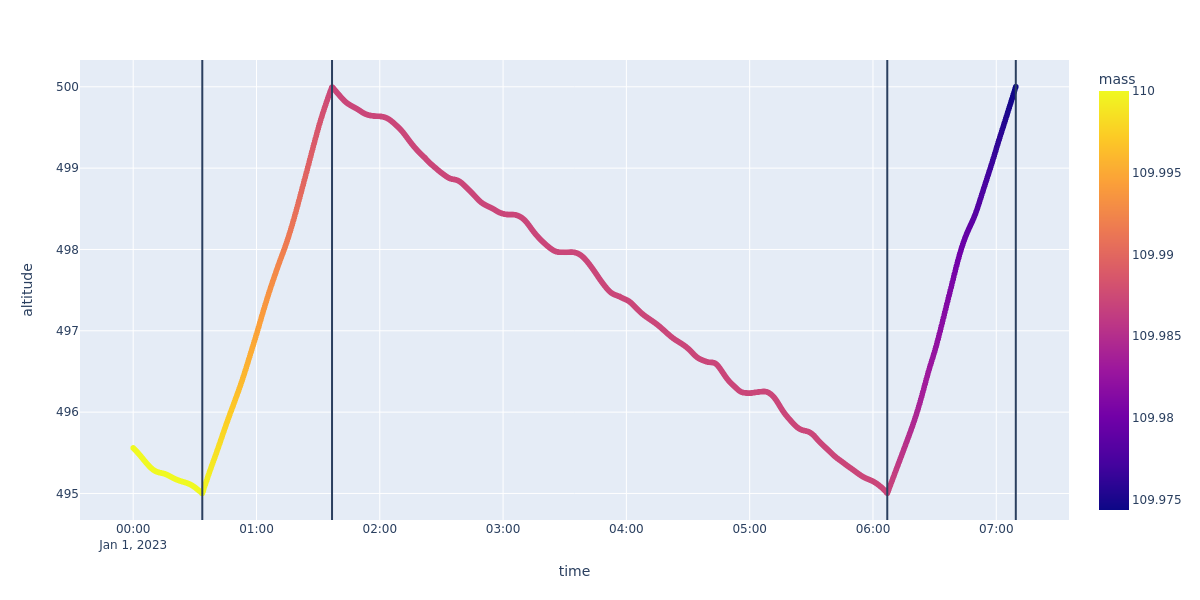

In [15]:
figure = px.scatter(
    df,
    x="time",
    y="altitude",
    color="mass",
    height=600,
    width=1200,
)
for segment_solution in sol.segment_solutions:
    time = segment_solution.states[-1].get_instant().get_date_time(Scale.UTC)
    figure.add_vline(x=time.isoformat())
figure.show("png")

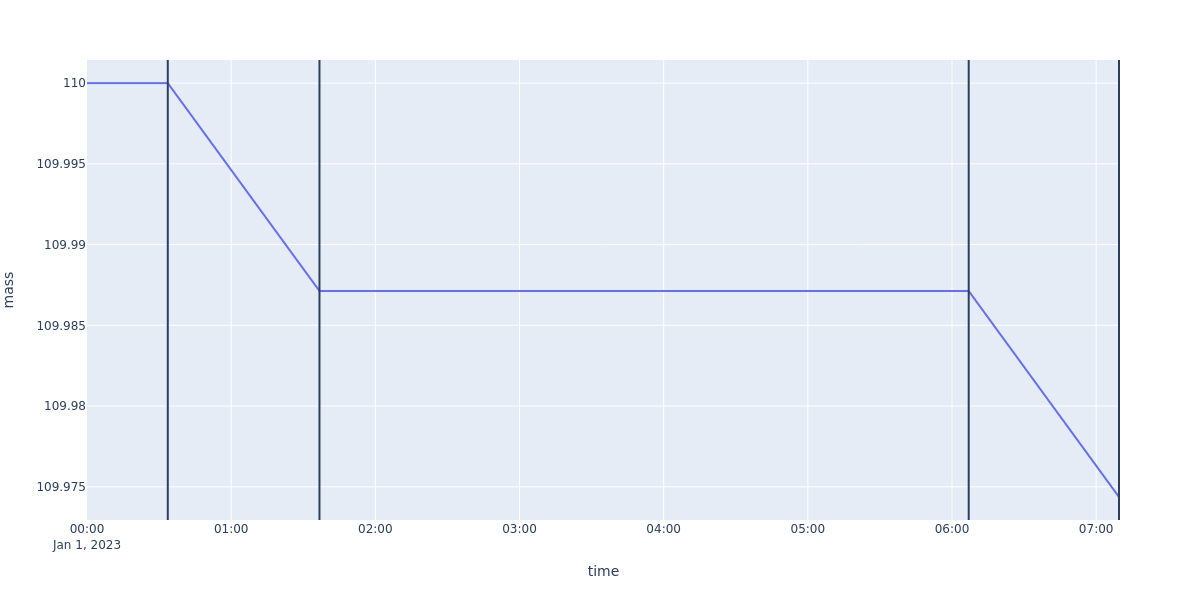

In [16]:
figure2 = px.line(
    df,
    x="time",
    y="mass",
    height=600,
    width=1200,
)
for segment_solution in sol.segment_solutions:
    time = segment_solution.states[-1].get_instant().get_date_time(Scale.UTC)
    figure2.add_vline(x=time.isoformat())
figure2.show("png")

---